In [122]:
import numpy as np
import pandas as pd 
import statsmodels.api as sm
import matplotlib
import matplotlib.pyplot as plt
import os 
import datetime as dt
import statsmodels as sm
import math

In [123]:
#Importing evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [124]:
#setting working directory
os.chdir("C:/Users/mah/Desktop/M5_Wallmart_Challenge")

In [125]:
#reading in the revenue_CA_1_FOODS_day time series csv
#setting the index which was saved as a row back as the index
revenue_CA_1_FOODS_day = pd.read_csv("revenue_CA_1_FOODS_day.csv", index_col='date')

In [126]:
#defining the training and evaluation set
#training data
y = revenue_CA_1_FOODS_day[:-365]
#evaluation(prediction) data
y_predict = revenue_CA_1_FOODS_day[-365:]

In [127]:
'''
Initialization according to Hyndman et al. 2008 p.23

1.Initial seasonal Component
  computing a 2xm  moving average: this means computing a m times moving average followed by a 2 times moving average.
  Explained in Forecastin Principles: https://otexts.com/fpp2/moving-averages.html (Moving averages of Moving averages)
  The 2xm moving average is computed for the first year of the data: y[:371].
'''
f = y[:371].rolling(window=7).mean()
f = f.rolling(window=2).mean()
d = y[7:371]/f[7:]

In [128]:
#making the Index of d to a datetime variable
d.index = pd.to_datetime(d.index, format='%Y-%m-%d')

In [129]:
#Check what weekday the first observation is: Day 5 --> Saturday (Monday is =0)
pd.to_datetime(y.index, format='%Y-%m-%d')[0].weekday()

5

In [130]:
#grouping d by the day of the week and computing the means
s_inits = d.groupby(d.index.dayofweek).mean()

In [131]:
#Define all inital seasonal values
#Note:The oldes value is the current seasonal
s_init7 = s_inits.at[5, 'revenue']
s_init6 = s_inits.at[4, 'revenue']
s_init5 = s_inits.at[3, 'revenue']
s_init4 = s_inits.at[2, 'revenue']
s_init3 = s_inits.at[1, 'revenue']
s_init2 = s_inits.at[0, 'revenue']
s_init  = s_inits.at[6, 'revenue']

In [132]:
#Normalizing the seasonal indices so they sum up to m
#done by dividing them all by there total sum and multiplying with m (m=7)
total = s_init7 + s_init6 + s_init5 + s_init4 + s_init3 + s_init2 + s_init

multiplier = 7 / total

s_init7 = s_init7 * multiplier
s_init6 = s_init6 * multiplier
s_init5 = s_init5 * multiplier
s_init4 = s_init4 * multiplier
s_init3 = s_init3 * multiplier
s_init2 = s_init2 * multiplier
s_init  = s_init * multiplier

In [133]:
'''
Initial Level and slope components
Hyndman 2008 p.23-24

Basically it is a Linear regression of time on the first 10 seasonally adusted values.
The coefficient of this Linear regression becomes the trend starting parameter.
The Intercept of the linear regression becomes the level starting parameter.
'''
#creating a dataframe containing the first 10 values seasonaly adjusted (values) and a time index (t)
first_10 = pd.DataFrame()
first_10['values'] = np.zeros(10)
first_10['t'] = range(0,10)
#computing the seasonal adjustment
#first creating a data frame with the first 10 seasonal adjustments
s_intit_all = s_init7,s_init6,s_init5,s_init4,s_init3,s_init2,s_init,s_init7,s_init6,s_init5
s_intit_all = pd.DataFrame(s_intit_all, columns=['inits'])
#computing the seasonally adjusted values
for i in range(0,10):
    first_10.at[i,'values'] = y['revenue'][i] / s_intit_all.at[i,'inits']

In [134]:
#Computing the Linear regression
from sklearn.linear_model import LinearRegression
#computing a regression of time on the first 10 seasonally adjusted values
reg = LinearRegression().fit(first_10['t'].values.reshape(-1,1),first_10['values'].values.reshape(-1,1))

In [135]:
#Intial Slope component
#Note: the two zeros in squared brackets take out the pure scalar value out of the array result
b_init = reg.coef_[0][0]

In [136]:
#Initial Level component
#Note: same reason for the zero as above
l_init = reg.intercept_[0]

In [137]:
def model(params, y):

    """
    1.This function runs an ETS(M,Ad,M) model. This is a Error, Trend, Seasonality exponential smoothing model.
      The first M stands for multiplicativ or relativ errors, the Ad for an additiv dampend trend and the last M for 
      multiplikativ seasonality. The actual computation of the fit model is done in the function ETS_M_Ad_M which further
      contains the functions calc_new_estimates, calc_error, save_estimates and seasonal_matrices. These are all explained in 
      the following code.
    
    2.The Inputs are for an array of model parameters (param) and the time series to fit (y).
      Params includes the smoothing factors and starting values for the level, trend and seasonality.
      
      Time independent smoothing parameters:
      alpha = level smoothing coefficient
      beta = trend smoothing coefficient
      gamma = seasonality smoothing coefficient
      omega = trend dampening coefficient
      
      Initial states computed above according to Hyndman 2008.
      l_init_HM = initial level
      b_init_HM = initial trend
      s_init7_HM ... s_init_HM = initial seasonal component where the number determines the lag of the dummy
    
    3.The function returns the sum of squared error of the fitted model. This allows the model to be inputed 
      into an optimizer which minimizes the sum of squared residuals dependent on the input parameters (param). 
      Following Hyndman 2008 p.69 the Adjusted Least Squared (ALS) estimate is equal to the ML estimate 
      in the case of homoskedastic errors. As we incorperate the heteroskedasticity of the series threw 
      multiplicativ components this assumption is valid.
    """

    alpha = params[0] 
    beta = params[1]
    gamma = params[2]
    omega = params[3]
    l_init_HM = params[4]
    b_init_HM = params[5]
    #creating a vertical vector of weekly seasonality dummies
    s_init_HM = np.vstack(params[6:13]) #recall setting 6:13 means 6,7,8,9,10,11,12
    
    #printing the parameter estimates in each optimization step
    #It helps to find errors
    print('alpha:', alpha,'beta:', beta,'gamma', gamma, 'omega', omega,
          l_init_HM,b_init_HM,s_init_HM)

    
    results = ETS_M_Ad_M(alpha,beta,gamma,omega,
          l_init_HM,b_init_HM,s_init_HM,y)
    
    error_list = results['errors_list']
    
    error_list = [number ** 2 for number in error_list]
    
    error_sum = sum(error_list)
    
    #Prints the current so that during the optimization it becomes visible if it makes progress
    print(error_sum)
   
    return error_sum


In [138]:
def calc_new_estimates(l_past, b_past, s_past, alpha, beta, omega, gamma, e, weekly_transition_matrix, weekly_update_vector):
    
    """
    1.This function updates the state estimates of the ETS(M,Ad,M) model l_past, b_past, s_past by the innovations/errors
      of each period. It is a part of the loop of the fit calculator of the model. Note that it also moves up the dummies
      in the seasonality vector. Further it includes an exception printing all parameters for the case that computation issues
      arise. This helps to identify possible issues and was suggested by Lucca Furrer.
    
    2.The Inputs are all past states, the smoothing parameters and the weekly_transition_matrix and weekly_update_vector
      required to update the current dummy, put it at the bottom of the vector and move the dummies up one position each period.
      
      Past state estimates:
      l_past = past level
      b_past = past trend
      s_past = past seasonal dummy vector
      
      Time independent smoothing parameters:
      alpha = level smoothing coefficient
      beta = trend smoothing coefficient
      gamma = seasonality smoothing coefficient
      omega = trend dampening coefficient
      
      constant matrix and vector for the seasonality:
      weekly_transition_matrix = serves the purpose of pushing all dummies up one position 
                                 while the current dummy goes to the bottom
      weekly_update_vector = is zero for all parameters except the current dummy in last position, which is updated by e.
    
    3.The function returns the updated states.
      l = updated level
      b = updated trend
      s = updated seasonality vector
    
    """
    try:
        l = (l_past + omega * b_past) * (1 + alpha * e)
        b = omega * b_past + beta * (l_past + omega * b_past) * e
        s = np.dot(weekly_transition_matrix,s_past) + weekly_update_vector * gamma * e
    except:
        print('lpast: ',l_past) 
        print('bpast', b_past) 
        print('spast', s_past) 
        print('alpha', alpha) 
        print('beta', beta) 
        print('omeag', omega) 
        print('gamma', gamma) 
        print('error', e)

    return l,b,s


In [139]:
def calc_error(l_past, b_past, s_past, omega, y, i):
    
    """
    1.This function calculates the point forecast, the relativ and absolute forecasting error of the ETS(M,Ad,M) model.
      It is a part of the loop of the fit calculator of the model and thus time i dependent. The absolute errors are computed
      for the sum of squared errors. Note that the sum of squared errors could also be computed with the relativ errors.
    
    2.The Inputs are all past states and the trend dampening factor, the time point i and the time series to estimate y.
      
      Past state estimates:
      l_past = past level
      b_past = past trend
      s_past = past seasonal dummy vector
      
      Time independent smoothing parameters:
      omega = trend dampening coefficient
      
      time dependent:
      y = time series
      i = time
    
    3.The function returns the point forecast, the relativ and absolute error.
      mu = point forecast
      e = relativ error
      e_absolute = absolute error
    
    """
    
    mu = (l_past + omega * b_past) * s_past[0]
    
    e = (y[i] - mu) / y[i]

    e_absolute = y[i] - mu

    return mu, e, e_absolute


In [140]:
def save_estimates(errors_list,point_forecast,l_list,b_list,s_list,e_absolute,mu,l_past,b_past,s_past):
    errors_list.append(e_absolute) 
    
    """
    1.This function simply appends the state estimates, the point forecast and the absolute error of each period 
      to previously defined lists in the ETS(M,Ad,M) model. It is a part of the loop of the fit calculator of the model.
    
    2.The Inputs are all past states, the point forecast, the absolute error and their respective lists
      
      Past state estimates:
      l_past = past level
      b_past = past trend
      s_past = past seasonal dummy vector
      
      mu = point forecast
      e_absolute = absolute error
      
      Lists accoridng to the above variables:
      errors_list
      point_forecast
      l_list
      b_list
      s_list
    
    3.The function returns the updated Lists.
      errors_list
      point_forecast
      l_list
      b_list
      s_list
    
    """
    
    point_forecast.append(mu)
    l_list.append(l_past)
    b_list.append(b_past)
    s_list.append(s_past[0])
    
    return errors_list, point_forecast, l_list, b_list, s_list


In [141]:
def seasonal_matrices():
    
    '''
    1. This function simply defines the weekly transition matrix and weekly updating matrix needed i nthe computation of
       new weekly seasonality dummies. The function is part of the fit function allthough it is part of the initialisation
       and merly used in the loop as new state estimates are computed.
       
    2. It has no inputs allthough it can be made more general at which point it would include a scalar as input containg the 
       length of the seasonality. Here it is 7
       
    3. It returns the above weekly transition matrix and the weekly updating matrix.
       weekly_transition_matrix
       weekly_update_vector
    
    '''
    
    #defining weekly transition matrix:
    #1. defining first column of zeros (1 row to short)
    col_1 = np.vstack(np.zeros(6))
    #2. defining identity matrix 1 row and column to small
    col_2_6 = np.identity(6)
    #3. adding the 1 column and the identity matrix, now all states are updated to jump up one step in the state vector
    matrix_6 = np.hstack((col_1,col_2_6))
    #4. creating a final row in which the current state is put in last place and will be added by an update
    row_7 = np.concatenate((1,np.zeros(6)), axis = None)
    #5. adding the last row to the matrix to make it complete
    weekly_transition_matrix = np.vstack((matrix_6,row_7))
    
    #defining the weekly updating vector
    weekly_update_vector = np.vstack(np.concatenate((np.zeros(6),1), axis = None))
    
    return weekly_transition_matrix, weekly_update_vector

In [142]:
def ETS_M_Ad_M(alpha,beta,gamma,omega,
          l_init_HM,b_init_HM,s_init_HM,y):
    
    '''
    1.This function computes the fit of the ETS(M,Ad,M) model for given initial and smoothing parameters.
      It is given these inputs by the model function and itself contains the functions 
      calc_new_estimates, calc_error, save_estimates and seasonal_matrices. It first defines time t as the length of y.
      Further it creates lists for parameters to return. Then it initialises by setting th initial states to be the past states.
      This allows the loop to start where one step ahead forecasts and errors are computed. This is followed by an update
      of the states with the new errors and then a redefinition of the states which in turn restarts the loop for the next period.
      
    2.Its inputs are the smoothing parameters, the initial states and the time series y.
      
      Time independent smoothing parameters:
      alpha = level smoothing coefficient
      beta = trend smoothing coefficient
      gamma = seasonality smoothing coefficient
      omega = trend dampening coefficient
      
      Initial states computed above according to Hyndman 2008.
      l_init_HM = initial level
      b_init_HM = initial trend
      s_init7_HM ... s_init_HM = initial seasonal component where the number determines the lag of the dummy
      
      y = time series
      
    3.The function returns lists of the fit errors, the point forecasts and the states.
      errors_list
      point_forecast
      l_list
      b_list
      s_list
    
    '''
    
    #computing the number of time points as the length of the forecasting vector
    t = len(y)
    #defining lists for parameters to save
    errors_list = list()
    point_forecast = list()
    l_list = list()
    b_list = list()
    s_list = list()
    

    #Initilaisation
    l_past = l_init_HM
    b_past = b_init_HM
    s_past = s_init_HM
    
    #defining the seasonal matrices for the calculation of new state estimates
    weekly_transition_matrix, weekly_update_vector = seasonal_matrices()



    #computation loop:
    for i in range(0,t): 

        #compute one step ahead  forecast for timepoint i
        mu, e, e_absolute = calc_error(l_past, b_past, s_past, omega, y, i)
        
        #save estimation error for Likelihood computation as well as the states and forecasts (fit values)
        errors_list, point_forecast, l_list, b_list, s_list = save_estimates(errors_list,point_forecast,l_list,b_list,s_list,
                                                                         e_absolute,mu,l_past,b_past,s_past)
    

        #Updating all state estimates with the information set up to time point i
        l,b,s = calc_new_estimates(l_past, b_past, s_past, alpha, beta, omega, gamma, e, weekly_transition_matrix, weekly_update_vector)
        
        #denote updated states from i as past states for time point i+1 in the next iteration of the loop
        l_past = l
        b_past = b
        s_past = s

    return  {'errors_list' : errors_list, 'point forecast' : point_forecast,
             'l_list' : l_list, 'b_list' : b_list, 's_list' : s_list}

In [243]:
#Defining Starting Parameters 
Starting_Parameters = [0.1, #alpha
                       0.01, #beta
                       0.01, #gamma
                       0.99, #omega --> all starting values according to Hyndman 2008 p.24
                       l_init,
                       b_init,
                       s_init7,
                       s_init6,
                       s_init5,
                       s_init4,
                       s_init3,
                       s_init2,
                       s_init]

#Training Data = Data - last 31 Days
#optimal starting parameters (the minimum found with above starting parameters) is at the following point in the parameter space:
Starting_Parameters_optimal = [4.28633972e-01, 1.00000000e-06, 1.77737151e-02, 9.99900000e-01,
       5.55499166e+03, 3.95146691e+01, 1.26607536e+00, 1.27730263e+00,
       9.52062778e-01, 8.46464228e-01, 8.15481901e-01, 8.38297619e-01,
       1.01900469e+00]
#Optima values found after running the above optimal values again threw the optimizer
Starting_Parameters_optimal =[7.78309081e-01, 1.00000000e-06, 1.77737151e-02, 9.99900000e-01,
       5.55481265e+03, 2.29283311e+02, 1.26152182e+00, 1.27730263e+00,
       9.52062778e-01, 8.46464228e-01, 8.15481901e-01, 8.38297619e-01,
       1.01900469e+00]


#Training Data = Data - last 365 Days
#Optimal Starting parameters after running the optimal starting parameters of second iteration from above
Starting_Parameters_optimal = [4.35897413e-01, 1.00000000e-06, 1.62051901e-02, 9.99900000e-01,
       5.55474894e+03, 4.12945873e+01, 1.25765230e+00, 1.27715921e+00,
       9.52618076e-01, 8.47985098e-01, 8.17593151e-01, 8.39002459e-01,
       1.01599286e+00]
#after runnign the above again
Starting_Parameters_optimal = [4.36312355e-01, 1.00000000e-06, 1.57826006e-02, 9.99900000e-01,
       5.55138863e+03, 4.28454881e+01, 1.22976063e+00, 1.24907450e+00,
       9.31617425e-01, 8.29350932e-01, 7.99425333e-01, 8.20600121e-01,
       9.93568917e-01]#
#after running the above again
Starting_Parameters_optimal = [4.36280927e-01, 1.00000000e-06, 1.58534640e-02, 9.99900000e-01,
       5.55138434e+03, 4.23243261e+01, 1.22952802e+00, 1.24884049e+00,
       9.31406277e-01, 8.29147150e-01, 7.99223706e-01, 8.20396970e-01,
       9.93353311e-01]

In [244]:
 from scipy.optimize import minimize, LinearConstraint, NonlinearConstraint

In [245]:
bounds = [(0.000001,0.9999),(0.000001,0.9999),(0.000001,0.9999),(0.000001,0.9999),(-np.inf,np.inf),(-np.inf,np.inf),
                        (-2,2),(-2,2),(-2,2),(-2,2),(-2,2),(-2,2),(-2,2)]
res = minimize(model, Starting_Parameters_optimal, args=(np.array(y['revenue'])), method='L-BFGS-B', bounds = bounds)

alpha: 0.436312355 beta: 1e-06 gamma 0.0157826006 omega 0.9999 5551.38863 42.8454881 [[1.22976063]
 [1.2490745 ]
 [0.93161742]
 [0.82935093]
 [0.79942533]
 [0.82060012]
 [0.99356892]]
[8.7929415e+08]
alpha: 0.436312365 beta: 1e-06 gamma 0.0157826006 omega 0.9999 5551.38863 42.8454881 [[1.22976063]
 [1.2490745 ]
 [0.93161742]
 [0.82935093]
 [0.79942533]
 [0.82060012]
 [0.99356892]]
[8.7929415e+08]
alpha: 0.436312355 beta: 1.0099999999999999e-06 gamma 0.0157826006 omega 0.9999 5551.38863 42.8454881 [[1.22976063]
 [1.2490745 ]
 [0.93161742]
 [0.82935093]
 [0.79942533]
 [0.82060012]
 [0.99356892]]
[8.79294204e+08]
alpha: 0.436312355 beta: 1e-06 gamma 0.0157826106 omega 0.9999 5551.38863 42.8454881 [[1.22976063]
 [1.2490745 ]
 [0.93161742]
 [0.82935093]
 [0.79942533]
 [0.82060012]
 [0.99356892]]
[8.7929415e+08]
alpha: 0.436312355 beta: 1e-06 gamma 0.0157826006 omega 0.9999000100000001 5551.38863 42.8454881 [[1.22976063]
 [1.2490745 ]
 [0.93161742]
 [0.82935093]
 [0.79942533]
 [0.82060012]
 

[8.79292263e+08]
alpha: 0.43628111580976753 beta: 1e-06 gamma 0.015853061820636626 omega 0.9999 5551.3843624034425 42.32740187784166 [[1.22952938]
 [1.24884187]
 [0.93140753]
 [0.82914836]
 [0.7992249 ]
 [0.82039818]
 [0.99335458]]
[8.79292263e+08]
alpha: 0.43628111580976753 beta: 1e-06 gamma 0.015853061820636626 omega 0.9999 5551.3843624034425 42.32740187784166 [[1.22952938]
 [1.24884187]
 [0.93140753]
 [0.82914836]
 [0.7992249 ]
 [0.82039817]
 [0.99335459]]
[8.79292263e+08]
alpha: 0.43628064202142414 beta: 1e-06 gamma 0.01585407126136811 omega 0.9999 5551.384298819164 42.319682746433244 [[1.22952595]
 [1.24883841]
 [0.93140439]
 [0.82914533]
 [0.79922191]
 [0.82039516]
 [0.99335139]]
[8.79292263e+08]
alpha: 0.43628065202142413 beta: 1e-06 gamma 0.01585407126136811 omega 0.9999 5551.384298819164 42.319682746433244 [[1.22952595]
 [1.24883841]
 [0.93140439]
 [0.82914533]
 [0.79922191]
 [0.82039516]
 [0.99335139]]
[8.79292263e+08]
alpha: 0.43628064202142414 beta: 1.0099999999999999e-06 g

In [246]:
res

      fun: array([8.79292263e+08])
 hess_inv: <13x13 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 4.64975834e+05,  5.80760531e+09,  2.24876404e+06, -1.55425926e+09,
        1.19209290e+01,  9.53674316e+01, -5.77211380e+05, -3.80277634e+04,
        3.54385376e+05,  3.61084938e+05,  3.46624851e+05,  1.67226791e+05,
       -1.81174278e+05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 70
      nit: 2
   status: 0
  success: True
        x: array([4.36280927e-01, 1.00000000e-06, 1.58534640e-02, 9.99900000e-01,
       5.55138434e+03, 4.23243261e+01, 1.22952802e+00, 1.24884049e+00,
       9.31406277e-01, 8.29147150e-01, 7.99223706e-01, 8.20396970e-01,
       9.93353311e-01])

In [247]:
def fit_extracter(params, y):
    
    '''
    1.This function runs the optimal values threw the model to extract optimal (fitted) forecasts for the training data.
      In essence it is identical to the model function with the exception that it returns the fully array of lists given by the 
      ETS_M_Ad_M function.
      
     2.The Inputs are for an array of model parameters (param) and the time series to fit (y).
      Params includes the smoothing factors and starting values for the level, trend and seasonality.
      
      Time independent smoothing parameters:
      alpha = level smoothing coefficient
      beta = trend smoothing coefficient
      gamma = seasonality smoothing coefficient
      omega = trend dampening coefficient
      
      Initial states computed above according to Hyndman 2008.
      l_init_HM = initial level
      b_init_HM = initial trend
      s_init7_HM ... s_init_HM = initial seasonal component where the number determines the lag of the dummy
    
    3.The function returns the error, point forecast and states for every time point in sperate lists: 
      errors_list
      point forecast
      l_list
      b_list
      s_list
    '''
    
    alpha = params[0] 
    beta = params[1]
    gamma = params[2]
    omega = params[3]
    l_init_HM = params[4]
    b_init_HM = params[5]
    s_init_HM = np.vstack(params[6:13]) 
    
    results = ETS_M_Ad_M(alpha,beta,gamma,omega,
          l_init_HM,b_init_HM,s_init_HM,y)
   
    return results

In [248]:
#the fit extracter is run with the optimal values optained from the optimizer (res.x) and the time series y
fit = fit_extracter(res.x, np.array(y['revenue']))

In [249]:
#creating a data frame with the time seires as date object and index
fit_values = pd.DataFrame({'fitted' : fit['point forecast'], 'date' : pd.to_datetime(y.index)})
fit_values = fit_values.set_index('date')

In [250]:
#Important: in order to plot to time series together with the index being the date
#the indexes of both have to be an objekt of type: datetime
revenue_CA_1_FOODS_day.index =pd.to_datetime(revenue_CA_1_FOODS_day.index)

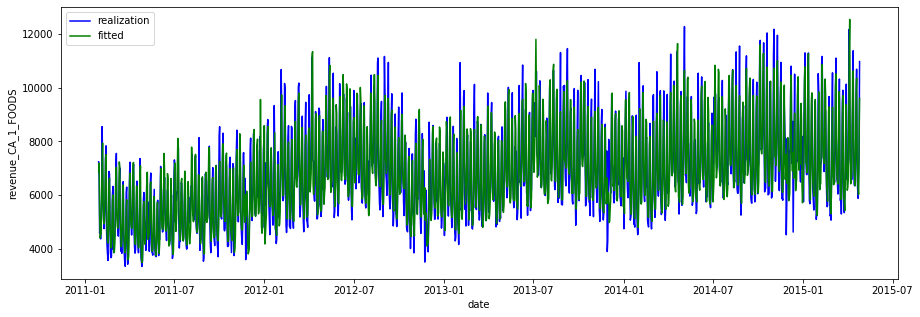

In [251]:
#Plot the fit and the training data set
plt.figure(figsize=(15, 5))
plt.plot(revenue_CA_1_FOODS_day[:-365], color = 'blue')
plt.plot(fit_values, color="green")
plt.xlabel("date")
plt.ylabel("revenue_CA_1_FOODS")
plt.legend(("realization", "fitted"),  
               loc="upper left")
plt.show()

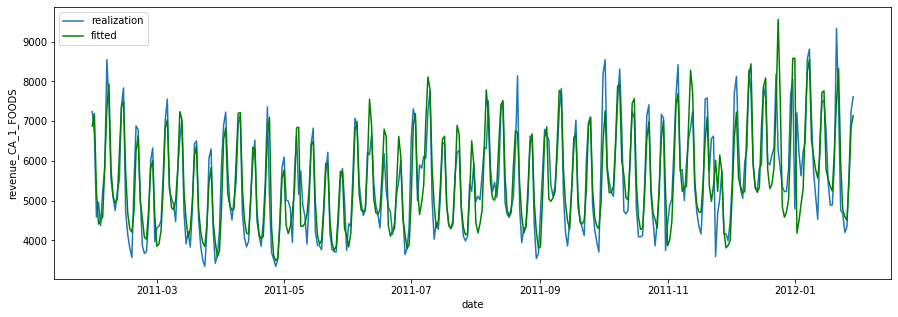

In [252]:
#Plot the fitted and training data set fpr the first year
plt.figure(figsize=(15, 5))
plt.plot(revenue_CA_1_FOODS_day[:366])
plt.plot(fit_values[:366], color="green")
plt.xlabel("date")
plt.ylabel("revenue_CA_1_FOODS")
plt.legend(("realization", "fitted"),  
               loc="upper left")
plt.show()

In [253]:
#extracting the last (most recent) values of the states for forecasting
#reversing the seasonals as the first one input into the forecast function needs to be the oldest seasonality
l_values = fit['l_list'][len(fit['l_list'])-1:]
b_values = fit['b_list'][len(fit['b_list'])-1:]
s_values = fit['s_list'][len(fit['s_list'])-7:]

In [254]:
#creating a list of all optimal parameters for forecasting
forecast_parameters = np.concatenate([res.x[0:4],l_values,b_values,s_values],axis=None)
forecast_parameters

array([4.36280927e-01, 1.00000000e-06, 1.58534640e-02, 9.99900000e-01,
       8.09401612e+03, 3.61347482e+01, 1.24694065e+00, 9.21144461e-01,
       7.92460026e-01, 7.80944389e-01, 7.64388998e-01, 9.32305926e-01,
       1.18172839e+00])

In [255]:
def forecasting(params, h):
    
    '''
    1.This function runs the optimal values threw the model to extract optimal predictions for the evaluation data.
      In essence it is identical to the model function with the exception that it does not give the time series but the 
      prediction horizon h. The computation of point forecast is done by passsing arguments to the ETS_M_Ad_M_forecast 
      function below.
      
     2.The Inputs are for an array of model parameters (param), the last state estimates from the optimal fit
       and the prediction intervall h.
       Params includes the smoothing factors and the last values for the level, trend and seasonality.
      
      Time independent smoothing parameters:
      alpha = level smoothing coefficient
      beta = trend smoothing coefficient
      gamma = seasonality smoothing coefficient
      omega = trend dampening coefficient
      
      last period T fit states computed above according to Hyndman 2008.
      l_init_HM = period T fit level
      b_init_HM = period T fit trend
      s_init7_HM ... s_init_HM = period T fit seasonal component where the number determines the lag of the dummy
    
    3.The function returns the point forecast and states for every time point in seperate lists: 
      point forecast
      l_list
      b_list
      s_list
    '''
    
    alpha = params[0] 
    beta = params[1]
    gamma = params[2]
    omega = params[3]
    l_init_HM = params[4]
    b_init_HM = params[5]
    s_init_HM = np.vstack(params[6:13])
    
    results = ETS_M_Ad_M_forecast(alpha,beta,gamma,omega,
          l_init_HM,b_init_HM,s_init_HM,h)
   
    return results

In [256]:
def ETS_M_Ad_M_forecast(alpha,beta,gamma,omega,
          l_init_HM,b_init_HM,s_init_HM,h):
    
    '''
    1.The ETS_M_Ad_M_forecast forecast function computes the forecast h steps ahead. As the essence of prediction
      is that errors e are unavailable this simplifies the prcess greatly compared to the ETS_M_Ad_M function.
      The ETS_M_Ad_M_forecast does not calculate new state estimates or errors but merly forecasts and updates the seasonal
      states.
      
    2. Inputs are the optimal parameters for the smoothing parameters and the last state estimates of the respective fit.
    
      Time independent smoothing parameters:
      alpha = level smoothing coefficient
      beta = trend smoothing coefficient
      gamma = seasonality smoothing coefficient
      omega = trend dampening coefficient
      
      last period T fit states computed above according to Hyndman 2008.
      l_init_HM = period T fit level
      b_init_HM = period T fit trend
      s_init7_HM ... s_init_HM = period T fit seasonal component where the number determines the lag of the dummy
      
      3.The function returns the point forecast and states for every time point in seperate lists: 
      point forecast
      l_list
      b_list
      s_list
    '''
    
    #computing the number of time points as the length of the forecasting vector
    t = h
    point_forecast = list()
    l_list = list()
    b_list = list()
    s_list = list()

    #Initilaisation
    l_past = l_init_HM
    b_past = b_init_HM
    s_past = s_init_HM
    
    #defining the seasonal matrices for the calculation of new state estimates
    weekly_transition_matrix, weekly_update_vector = seasonal_matrices()

    #computation loop:
    for i in range(1,h+1): #+1 because range(1,31): 1,..30, thus range(1,31+1): 1,...,31
        
        #compute one step ahead  forecast for timepoint t
        mu = (l_past + omega * b_past) * s_past[0]
        
        point_forecast.append(mu)
        l_list.append(l_past)
        b_list.append(b_past)
        s_list.append(s_past[0])

        #Updating
        #no changes in level (l) and slope (b) as they remain constant without new information
        #only changes in seasonality (s) as it cycles every 7 days, the effect of each individual seasonality is not updated
        
        s_past = np.dot(weekly_transition_matrix,s_past)
        

    return  {'point forecast' : point_forecast,
             'l_list' : l_list, 'b_list' : b_list, 's_list' : s_list}

In [257]:
#computing forecasts for the horizons 7,14,21,31,365 and saving the results
forecasts_7 = forecasting(forecast_parameters, 7)
forecasts_14 = forecasting(forecast_parameters, 14)
forecasts_21 = forecasting(forecast_parameters, 21)
forecasts_31 = forecasting(forecast_parameters, 31)
forecasts_365 = forecasting(forecast_parameters, 365)

In [258]:
#creating a data frame with the time series as date object and index for each forecasting horizon
#Note: np.concatenate the data to form it into one array

forecasted_values_7 = pd.DataFrame({'forecast' : np.concatenate(forecasts_7['point forecast'],axis=None),
                                      'date' : pd.to_datetime(y_predict.index[:7])})
forecasted_values_7 = forecasted_values_7.set_index('date')

forecasted_values_14 = pd.DataFrame({'forecast' : np.concatenate(forecasts_14['point forecast'],axis=None),
                                      'date' : pd.to_datetime(y_predict.index[:14])})
forecasted_values_14 = forecasted_values_14.set_index('date')

forecasted_values_21 = pd.DataFrame({'forecast' : np.concatenate(forecasts_21['point forecast'],axis=None),
                                      'date' : pd.to_datetime(y_predict.index[:21])})
forecasted_values_21 = forecasted_values_21.set_index('date')

forecasted_values_31 = pd.DataFrame({'forecast' : np.concatenate(forecasts_31['point forecast'],axis=None),
                                      'date' : pd.to_datetime(y_predict.index[:31])})
forecasted_values_31 = forecasted_values_31.set_index('date')

forecasted_values_365 = pd.DataFrame({'forecast' : np.concatenate(forecasts_365['point forecast'],axis=None),
                                      'date' : pd.to_datetime(y_predict.index)})
forecasted_values_365 = forecasted_values_365.set_index('date')

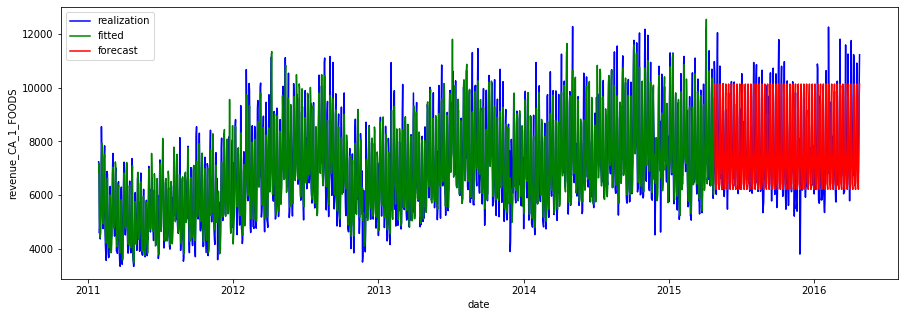

In [259]:
#Plot the results over the entire time span
plt.figure(figsize=(15, 5))
plt.plot(revenue_CA_1_FOODS_day, color = 'blue')
plt.plot(fit_values, color="green")
plt.plot(forecasted_values_365, color="red")
plt.xlabel("date")
plt.ylabel("revenue_CA_1_FOODS")
plt.legend(("realization", "fitted","forecast"),  
               loc="upper left")
plt.show()

In [260]:
#make sure the prediction data set index is a date variable for plotting
y_predict.index =pd.to_datetime(y_predict.index)

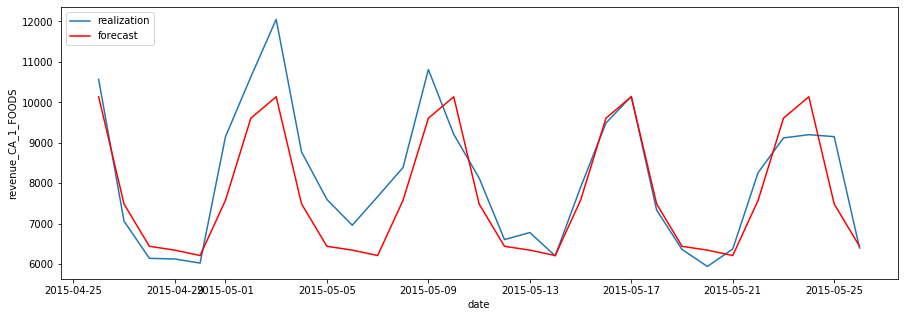

In [261]:
#Plot the first 31 days of the prediction data and their forecasts
plt.figure(figsize=(15, 5))
plt.plot(y_predict[:31])
plt.plot(forecasted_values_31, color="red")
plt.xlabel("date")
plt.ylabel("revenue_CA_1_FOODS")
plt.legend(("realization", "forecast"),  
               loc="upper left")
plt.show()

In [262]:
#defining the evaluation metrics
#from: https://mlflow.org/docs/latest/tutorials-and-examples/tutorial.html
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

In [263]:
#creating a table with the forecasting evaluation metric values for all four models
#each row contains the evaluation metrics for a model
#the loop runs threw range of 3 as we have three metrics (0,1,2)
fc_acc=pd.DataFrame(index=['rmse', 'mae', 'r2'])
fc_acc["7 Days"] = [eval_metrics(y_predict['revenue'][:7], forecasted_values_7['forecast'])[a] for a in range(0,3)]
fc_acc["14 Days"] = [eval_metrics(y_predict['revenue'][:14], forecasted_values_14['forecast'])[a] for a in range(0,3)]
fc_acc["21 Days"] = [eval_metrics(y_predict['revenue'][:21], forecasted_values_21['forecast'])[a] for a in range(0,3)]
fc_acc["31 Days"] = [eval_metrics(y_predict['revenue'][:31], forecasted_values_31['forecast'])[a] for a in range(0,3)]
fc_acc["365 Days"] = [eval_metrics(y_predict['revenue'], forecasted_values_365['forecast'])[a] for a in range(0,3)]

In [264]:
fc_acc

,7 Days,14 Days,21 Days,31 Days,365 Days
rmse,759.790394,1044.840627,896.804714,832.013710,876.502291
mae,592.276204,898.707659,723.816433,639.367666,654.725364
r2,0.847548,0.696500,0.729190,0.745337,0.695228


In [265]:
fc_acc.to_csv('ETS(M,Ad,M).csv') 